# Greedy Covariance Steering of a Car on 2D Plane

In [8]:
import numpy as np
import time
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from src.plot_tools import confidence_ellipse, set_axes_equal
import mpl_toolkits.mplot3d.art3d as art3d
from src.models import SimpleCar
plt.rc('text', usetex=True)

from src.covariance_steering_functions import (
    linearCovarianceSteeringDiscrete, 
    unscented_transform_with_feedback,
)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup model and simulation

In [9]:
# Define a simple linear system
N = 30

# Single-integrator model
model = SimpleCar(
    dt=0.05, 
    process_sigma=[1.e-3, 1.e-3, 2.e-2, 2.e-2], 
)

# Initial distribution
mu_0 = np.array([0., 0., 0., 1.])
Sigma_0 = np.diag([0.1, 0.2, 0.1, 0.1]) ** 2

# Target distribution
mu_f = np.array([1, 2, 0, 1])
Sigma_f = np.diag([0.1, 0.05, 0.05, 0.05]) ** 2

### Simulate

In [10]:
# Initialize matrices

mu = np.zeros((N+1, model.nx))
Sigma = np.zeros((N+1, model.nx, model.nx))
nu = np.zeros((N+1, model.nu))
u_star = np.zeros((N, model.nu))
K_star = np.zeros((N, model.nu, model.nx))
K_corr = np.zeros((model.nu, model.nx))
sigma_points_prior = np.zeros((N, model.nx*2+1, model.nx))
sigma_points_posterior = np.zeros((N, model.nx*2+1, model.nx))

mu[0] = mu_0
Sigma[0] = Sigma_0

# u_next = np.zeros(model.nu)
# K_next = np.zeros((2, model.nu, model.nx))
verbose = False

start_time = time.time()

progress_bar = tqdm(range(N))
for k in progress_bar:
    nu_prior = np.zeros(model.nu) if k==0 else u_next + K_next[0] @ mu[k-1] + K_next[1] @ mu[k]
    W = model.W
    if k < N-1:
        Ak, Bk, dk = model.linearize(mu[k], nu_prior)
        v, K = linearCovarianceSteeringDiscrete(Ak, Bk, dk, mu[k], Sigma[k], mu_f, Sigma_f, W, N - k, verbose=verbose, previous_soln=None)
        u_star[k] = v[0]
        K_star[k] = K[0,0]
        u_next = v[1]
        K_next = K[1,:2]
    else:
        u_star[k] = u_next
        K_star[k] = K_next[1]
        K_corr = K_next[0]

    # Propagate mean and covariance using the unscented transform
    u_corr = K_corr @ sigma_points_prior[k].T if k == N-1 else None
        
    mu[k+1], Sigma[k+1], sigma_points_prior[k], sigma_points_posterior[k] = unscented_transform_with_feedback(
        mu[k],
        Sigma[k],
        u_star[k],
        K_star[k],
        W,
        model.mean_step,
        u_corr=u_corr
    )
    
    if k < N-1:
        nu[k] = u_star[k] + K_star[k] @ mu[k]
    else:
        nu[k] = u_star[k] + K_star[k] @ mu[k] + K_corr @ mu[k-1]
        

print(f'Done. Time: {time.time() - start_time} s')

100%|██████████| 30/30 [13:19<00:00, 26.67s/it]

Done. Time: 800.0196647644043 s


### Monte Carlo

In [11]:
np.random.seed(1)

n_part = 400
x = np.zeros((N+1, n_part, model.nx))
u = np.zeros((N, n_part, model.nu))
x[0] = np.random.multivariate_normal(mu_0, Sigma_0, size=n_part)
progress_bar = tqdm(range(N))
for k in progress_bar:
    # Propagate particles
    for j in range(n_part):
        if k < N-1:
            u[k,j] = u_star[k] + K_star[k] @ x[k,j]
        else:
            u[k,j] = u_star[k] + K_star[k] @ x[k,j] + K_corr @ x[k-1,j]
            
        x[k+1,j] = model.step(x[k,j], u[k,j])

100%|██████████| 30/30 [00:01<00:00, 20.57it/s]


### Plot Results

/Users/atsol/research/covariance_steering/greedyGPCS/src/plot_tools.py:99: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


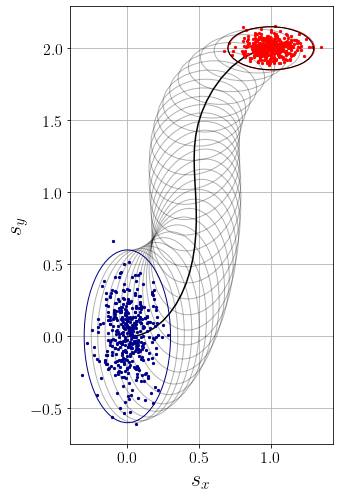

In [12]:
# Plot position uncertainty
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
#   ax.plot(x[:,:,0], x[:,:,1], lw=0.5) # Particle trajectories
ax.plot(mu[:,0], mu[:,1], c='k', lw=1.5, zorder=13)
#   ax.plot(sigma_points_prior[:,:,0], sigma_points_prior[:,:,1], c='b', lw=2)
ax.scatter(x[0,:,0], x[0,:,1], c='darkblue', s=5, zorder=15)
ax.scatter(x[-1,:,0], x[-1,:,1], c='r', s=5, zorder=15)
ax.add_patch(confidence_ellipse(mu_0[:2], Sigma_0[:2,:2], n_std=3., edgecolor='darkblue', zorder=14))
ax.add_patch(confidence_ellipse(mu_f[:2], Sigma_f[:2,:2], n_std=3., edgecolor='r', zorder=14))
for k in range(1,N):
    ax.add_patch(confidence_ellipse(mu[k,:2], Sigma[k,:2,:2], n_std=3., edgecolor='k', zorder=14, alpha=0.3))
ax.add_patch(confidence_ellipse(mu[-1,:2], Sigma[-1,:2,:2], n_std=3., edgecolor='k', zorder=15))
ax.grid(True)
ax.set_aspect('equal', 'box')
ax.set_xlabel('$s_x$', fontsize=22)
ax.set_ylabel('$s_y$', fontsize=22)
plt.tick_params(axis='both', labelsize=16)

plt.tight_layout()
plt.savefig('figs/exact_position_uncertainties.pdf')
plt.savefig('figs/exact_position_uncertainties.png')


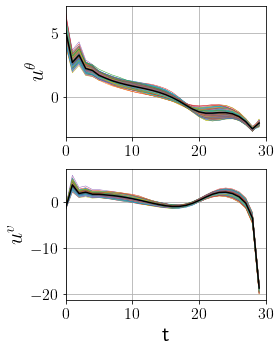

In [13]:
# Plot inputs
fig = plt.figure(figsize=(4,5))

# Plot u_1
ax = fig.add_subplot(211)
ax.plot(range(N), nu[:N,0], c='k', lw=1.5, zorder=10)
ax.plot(range(N), u[:,:,0], lw=0.5) # Particle trajectories
ax.grid(True)
ax.set_ylabel('$u^{\\theta}$', fontsize=22)
ax.set_xlim([0,N])
plt.tick_params(axis='both', labelsize=16)

# Plot u_2
ax = fig.add_subplot(212)
ax.plot(range(N), nu[:N,1], c='k', lw=1.5, zorder=10)
ax.plot(range(N), u[:,:,1], lw=0.5) # Particle trajectories
ax.grid(True)
ax.set_ylabel('$u^{v}$', fontsize=22)
ax.set_xlabel('t', fontsize=22)
ax.set_xlim([0,N])
plt.tick_params(axis='both', labelsize=16)

plt.tight_layout()
plt.savefig('figs/exact_inputs.pdf')
plt.savefig('figs/exact_inputs.png')

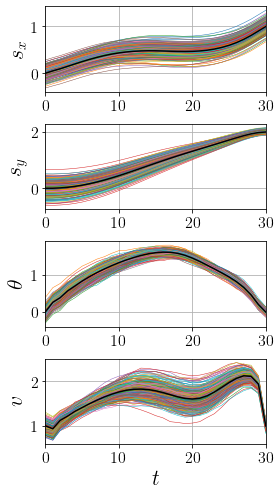

In [14]:
# Plot states
fig = plt.figure(figsize=(4,7))

# Plot x
ax = fig.add_subplot(411)
ax.plot(range(N+1), mu[:,0], c='k', lw=1.5, zorder=10)
ax.plot(range(N+1), x[:,:,0], lw=0.5) # Particle trajectories
ax.grid(True)
ax.set_ylabel('$s_x$', fontsize=22)
ax.set_xlim([0,N])
plt.tick_params(axis='both', labelsize=16)

# Plot y
ax = fig.add_subplot(412)
ax.plot(range(N+1), mu[:,1], c='k', lw=1.5, zorder=10)
ax.plot(range(N+1), x[:,:,1], lw=0.5) # Particle trajectories
ax.grid(True)
ax.set_ylabel('$s_y$', fontsize=22)
ax.set_xlim([0,N])
plt.tick_params(axis='both', labelsize=16)

# Plot theta
ax = fig.add_subplot(413)
ax.plot(range(N+1), mu[:,2], c='k', lw=1.5, zorder=10)
ax.plot(range(N+1), x[:,:,2], lw=0.5) # Particle trajectories
ax.grid(True)
ax.set_ylabel('$\\theta$', fontsize=22)
ax.set_xlim([0,N])
plt.tick_params(axis='both', labelsize=16)

# Plot velocity
ax = fig.add_subplot(414)
ax.plot(range(N+1), mu[:,3], c='k', lw=1.5, zorder=10)
ax.plot(range(N+1), x[:,:,3], lw=0.5) # Particle trajectories
ax.grid(True)
ax.set_ylabel('$v$', fontsize=22)
ax.set_xlabel('$t$', fontsize=22)
ax.set_xlim([0,N])
plt.tick_params(axis='both', labelsize=16)

plt.tight_layout()
plt.savefig('figs/exact_model_states.pdf')
plt.savefig('figs/exact_model_states.png')

### Save results

In [15]:
with open('data/cs_analytic.dat', 'wb') as f:
    pickle.dump([u_star, K_star, mu, Sigma, x, u], f)